In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Get the data

In [2]:
df = pd.read_csv("housing.csv")

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## EDA

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

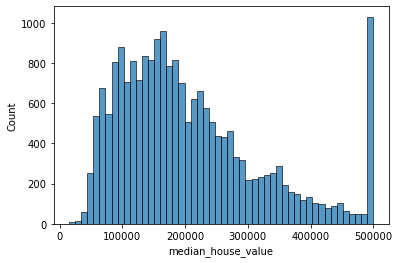

In [4]:
sns.histplot(df.median_house_value, bins=50)

In [5]:
df = df[['latitude', 'longitude', 'housing_median_age', 'total_rooms',
         'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']]

## Q1

Find a feature with missing values. How many missing values does it have?

In [6]:
df.isnull().sum()[df.isnull().sum() > 0]

total_bedrooms    207
dtype: int64

### Answer = 207

## Q2

What's the median (50% percentile) for variable 'minimum_nights'?

In [7]:
df["population"].median()

1166.0

### Answer = 1166

## Split the data

- Shuffle the initial dataset, use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Apply the log transformation to the price variable using the np.log1p() function.
- Make sure that the target value ('price') is not in your dataframe.

In [8]:
n = len(df)
n_train = int(n * 0.6)
n_val = int(n * 0.2)
n_test = n - n_train - n_val
n_train, n_val, n_test

(12384, 4128, 4128)

In [9]:
idxs = np.arange(len(df))
idxs

array([    0,     1,     2, ..., 20637, 20638, 20639])

In [10]:
np.random.seed(42)
np.random.shuffle(idxs)

In [11]:
df_train = df.iloc[idxs[:n_train]]
df_val = df.iloc[idxs[n_train:n_train+n_val]]
df_test = df.iloc[idxs[n_train+n_val:]]
len(df_train), len(df_val), len(df_test)

(12384, 4128, 4128)

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
y_train = np.log1p(df_train["median_house_value"])
df_train.drop(columns="median_house_value", inplace=True)
y_val = np.log1p(df_val["median_house_value"])
df_val.drop(columns="median_house_value", inplace=True)
y_test = np.log1p(df_test["median_house_value"])
del df_test["median_house_value"]

## Q3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
    - For computing the mean, use the training only!
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)  
Which option gives better RMSE?

In [14]:
X_train_null = df_train.fillna(0)
X_train_mean = df_train.fillna(df_train.mean())
X_train_median = df_train.fillna(df_train.median())

In [15]:
X_val_null = df_val.fillna(0)
X_val_mean = df_val.fillna(df_val.mean())
X_val_median = df_val.fillna(df_val.median())

In [16]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [17]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return round(np.sqrt(mse), 2)

In [18]:
w_0_null, w_null = train_linear_regression(X_train_null, y_train)
w_0_mean, w_mean = train_linear_regression(X_train_mean, y_train)
w_0_median, w_median = train_linear_regression(X_train_median, y_train)

In [19]:
y_null_pred_val = w_0_null + X_val_null.dot(w_null)
y_mean_pred_val = w_0_mean + X_val_mean.dot(w_mean)
y_median_pred_val = w_0_median + X_val_median.dot(w_median)

In [20]:
print("null:" + str(rmse(y_val, y_null_pred_val)))
print("mean:" + str(rmse(y_val, y_mean_pred_val)))
print("median:" + str(rmse(y_val, y_median_pred_val)))

null:0.33
mean:0.33
median:0.33


<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

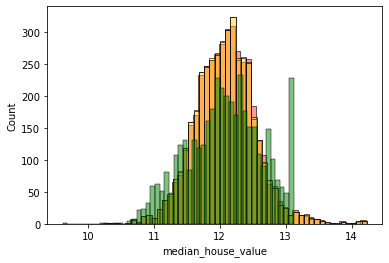

In [21]:
sns.histplot(y_null_pred_val, alpha=0.4, bins=50, color='red')
sns.histplot(y_mean_pred_val, alpha=0.3, bins=50, color='orange')
sns.histplot(y_median_pred_val, alpha=0.2, bins=50, color='yellow')
sns.histplot(y_val, alpha=0.5, bins=50, color='green')

### Answer = Both are equally good

## Q4

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?  
If there are multiple options, select the smallest r.

In [22]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    print(reg)
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [23]:
X_train = df_train.fillna(0)
X_val = df_val.fillna(0)

In [24]:
reg_rmse = pd.DataFrame(columns=["Regularise parameter", "RMSE"])
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_reg_val = w_0 + X_val.dot(w)
    rmse_val = rmse(y_val, y_reg_val)
    reg_rmse = reg_rmse.append({'Regularise parameter': r, 'RMSE': rmse_val}, ignore_index = True)
reg_rmse.head(10)

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 1.e-06]]
[[0.0001 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0001 0.     0.     0.     0.     0.     0.     0.    ]
 [

,Regularise parameter,RMSE
0,0.000000,0.33
1,0.000001,0.33
2,0.000100,0.33
3,0.001000,0.33
4,0.010000,0.33
5,0.100000,0.33
6,1.000000,0.33
7,5.000000,0.34
8,10.000000,0.34


### Answer = 0

## Q5

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))  
Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [216]:
rmse_list = []

for r in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(r)
    np.random.shuffle(idxs)

    df_train = df.iloc[idxs[:n_train]]
    df_val = df.iloc[idxs[n_train:n_train+n_val]]
    df_test = df.iloc[idxs[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(y_train_orig)
    y_val = np.log1p(y_val_orig)
    y_test = np.log1p(y_test_orig)
    
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    X_train = df_train.fillna(0)
    X_val = df_val.fillna(0)

    w_0, w = train_linear_regression(X_train, y_train)
    
    y_reg_val = w_0 + X_val.dot(w)
    rmse_val = rmse(y_val, y_reg_val)
    
    rmse_list.append(rmse_val)
    
    print(r, w_0, rmse_val)

0 -11.400369216052377 0.35
1 -11.746163468804326 0.34
2 -11.401205412465826 0.34
3 -11.941066088562632 0.34
4 -11.830608322337092 0.35
5 -11.093921009870233 0.34
6 -11.588010466050784 0.35
7 -11.701374810221067 0.34
8 -11.736481673631967 0.34
9 -11.486795431251362 0.34


In [217]:
print(round(np.std(rmse_list), 3))

0.005


### Answer = 0.005

## Q6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.  
What's the RMSE on the test dataset?

In [226]:
np.random.seed(9)
np.random.shuffle(idxs)

df_train = df.iloc[idxs[:n_train+n_val]]
df_test = df.iloc[idxs[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_orig = df_train.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(y_train_orig)
y_test = np.log1p(y_test_orig)

del df_train['median_house_value']
del df_test['median_house_value']

X_train = df_train.fillna(0)
X_test = df_test.fillna(0)

w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

y_reg_test = w_0 + X_test.dot(w)
rmse_test = rmse(y_test, y_reg_test)

In [227]:
rmse_test

0.35

### Answer = 0.35